# 1. 요약 : 절차
  
## 1.1. 데이터 준비
  - 1초 동안 소리나는 단어를 구분하기
  - 음성데이터 : (50620, 8000)
  
## 1.2. 데이터 분석 / 전처리
  - 1차원인 음성데이터를 2차원인 spectrogram 데이터로 변환
  - 트레인 데이터 용량이 커서 실행되지 않아 20000개의 데이터로만 실행

## 1.3. train, validation 데이터 분리
  - train, validation = 18000, 2000


## 1.4. 학습
  - 주피터 노트북 커널에서 실행되지 않음
  - 구글 코랩에서 실행시킴

## 1.5. 학습결과 도식화
 

## 1.6. 테스트 데이터로 정확성 측정
  - accuracy : 94.4%
  - loss : 0.179
  
    
      
      
# 2. 회고

- 왜 이렇게 오류가 많이 발생하는 것일까? 
    - 화요일 lms에 입력할 때는 오류가 없었음
    - 주피터 노트북에서 실행하면서 오류 불생
    - librosa 임포트 오류
    - 메모리 오류 : train data를 분류하면서 2기가를 넘었다고 처리가 되지 않음
      - 검색과 오류 수정 메시지 대로 했지만 변화없음
    - 여러가지 오류들이 겹쳐서 계속 실행되지 않음
    - 화요일 오후에 퍼실께서 원격조정하여 오류 겨우 찾아서 수정 : 18시 30분
      - 하지만 다시 실행하자 커널이 다운되며 계속 restart / dead kernel이 반복됨
    - 화요일 20시 30분 : 코랩에서 작업하기로 결정
      - 소스코드와 데이터를 구글 드라이버에 업로드
      - 마운트 / 경로 모두 수정하여 작업
      - 구글 GPU 사용하여 실행 : 21시 40분 작업 종료
      
    - 더이상 손을 대다가는 결과에 다시 오류가 발생할까 하는 걱정에 제출하기로 결정.
    

 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import IPython.display as ipd
import random


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/ssac/project/pro_05_audio/speech_wav_8000.npz'

In [5]:
#data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [6]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [7]:
# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수


#data = speech_data["wav_vals"][rand]
data = speech_data["wav_vals"][rand]

print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  23254
Wave data shape :  (8000,)
label :  ['down']


In [8]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [9]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data = label_data[:20000]

label_data.shape

(20000,)

In [10]:
print(speech_data["wav_vals"], speech_data["wav_vals"].shape)
type(speech_data["wav_vals"])

[[-1.27418665e-04 -1.12644804e-04 -1.86756923e-04 ... -1.62762426e-05
  -4.93293861e-04 -3.55132594e-04]
 [-3.06998868e-03 -4.10807552e-03 -3.31036211e-03 ... -4.67803935e-03
  -4.21488844e-03 -6.10053446e-03]
 [ 1.59116389e-04  1.11387717e-03 -1.25855627e-03 ... -9.50679742e-03
   1.47810066e-02  3.41885872e-02]
 ...
 [-7.13879392e-02  1.11577094e-01 -3.49124521e-01 ...  1.27255514e-01
  -2.06745356e-01  2.13672481e-02]
 [ 2.80666262e-01  1.76843733e-01 -8.22633058e-02 ...  4.30828370e-02
   8.51763189e-02 -1.32893130e-01]
 [-5.42262085e-02  1.66265428e-01  3.59905154e-01 ... -3.49392533e-01
   2.62163337e-02  2.09347770e-01]] (50620, 8000)


numpy.ndarray

In [11]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

specs_data = []
data = speech_data["wav_vals"]

for wav in data:
    stft = wav2spec(wav)
    specs_data.append(stft)
    
specs_data = np.array(specs_data)

# for i in range(len(speech_data["wav_vals"])):
#     spec = wav2spec(speech_data["wav_vals"][i])
#     specs_data.append(spec)

print(np.array(specs_data).shape)


(50620, 130, 126)


In [13]:
#del speech_data

In [12]:
specs_data = specs_data[:20000,:,:]
print(specs_data.shape)

(20000, 130, 126)


In [13]:
batch_size = 32
max_epochs = 10

# the save point
# checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ssac/project/pro_05_audio/wav'

# checkpoint_dir

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
#    fft = np.array(wav2spec(wav))
#    return np.array(wav2spec(wav)), label
    return wav, label

In [15]:
print(specs_data.shape)

(20000, 130, 126)


In [16]:
# data를 스펙트로그램으로 변환 후 실행

from sklearn.model_selection import train_test_split

sr = 130
sc = 126
train_wav, test_wav, train_label, test_label = train_test_split(specs_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav.shape)

train_wav = train_wav.reshape([-1, sr, sc, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, sc, 1])


(18000, 130, 126)


In [17]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (18000, 130, 126, 1)
train labels :  (18000,)
test data :  (2000, 130, 126, 1)
test labels :  (2000,)


In [18]:
del specs_data
#del speech_data
del label_data

In [ ]:
# train_wav = train_wav[:20000]
# train_label = train_label[:20000]

# print("train data : ", train_wav.shape)
# print("train labels : ", train_label.shape)


In [ ]:
# train_label = train_label.map(one_hot_label)
# test_label = test_label.map(one_hot_label)

In [ ]:
# 메모리 문제가 계속 나타나 트레인 데이터의 용량을 확인하기 위해 파일에 저장하여 확인 : 3Gbytes

# import sys
# data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/specs_data.txt'
# sys.stdout = open(data_path,'w')
# np.save(data_path, train_wav)

In [19]:
train_label.shape
#type(train_label)

(18000,)

In [ ]:
# dataset_1 = train_wav[:1000], train_label[:1000]
# dataset_2 = train_wav[1000:2000], train_label[1000:2000]

# train_dataset_1 = tf.data.Dataset.from_tensor_slices((dataset_1))
# train_dataset_1 = train_dataset_1.map(one_hot_label)
# train_dataset_1 = train_dataset_1.repeat().batch(batch_size=batch_size)
# print(train_dataset_1)

# train_dataset_2 = tf.data.Dataset.from_tensor_slices((dataset_2))
# train_dataset_2 = train_dataset_2.map(one_hot_label)
# train_dataset_2 = train_dataset_2.repeat().batch(batch_size=batch_size)
# print(train_dataset_2)

# train_dataset = np.concatenate(train_dataset_1, train_dataset_2)


In [20]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)



<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [21]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))
print(input_tensor)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

KerasTensor(type_spec=TensorSpec(shape=(None, 130, 126, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Loss

현재 라벨이 될 수 있는 12개의 class를 가지고 있습니다.
해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용하겠습니다.

In [22]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

Callback

    model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.
    모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.

In [23]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#history = model.fit(x_train, y_train, epochs=20, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [ ]:
#history_wav = model_wav.fit(train_wav, train_label, epochs = 90, batch_size = 50, validation_data = (test_wav, test_label))

In [25]:
# 시간 많이 소요됨. 이 셀만 실행하면 Kernel Restarting 메시지 나타남.
# 코랩에서 실행해보고 결과까지만 확인할 예정
# 빨간색으로 dead kernel 도 표시됨. 일주일을 메달렸지만 해결안됨.

history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )


Epoch 1/10
562/562 [==============================] - 84s 135ms/step - loss: 1.5173 - accuracy: 0.5141 - val_loss: 0.5208 - val_accuracy: 0.8291

Epoch 00001: val_loss improved from inf to 0.52083, saving model to /content/drive/MyDrive/Colab Notebooks/ssac/project/pro_05_audio/wav
Epoch 2/10
562/562 [==============================] - 76s 136ms/step - loss: 0.3502 - accuracy: 0.8936 - val_loss: 0.3171 - val_accuracy: 0.8982

Epoch 00002: val_loss improved from 0.52083 to 0.31710, saving model to /content/drive/MyDrive/Colab Notebooks/ssac/project/pro_05_audio/wav
Epoch 3/10
562/562 [==============================] - 76s 135ms/step - loss: 0.2031 - accuracy: 0.9432 - val_loss: 0.2673 - val_accuracy: 0.9138

Epoch 00003: val_loss improved from 0.31710 to 0.26732, saving model to /content/drive/MyDrive/Colab Notebooks/ssac/project/pro_05_audio/wav
Epoch 4/10
562/562 [==============================] - 76s 135ms/step - loss: 0.1264 - accuracy: 0.9664 - val_loss: 0.2598 - val_accuracy: 0.916

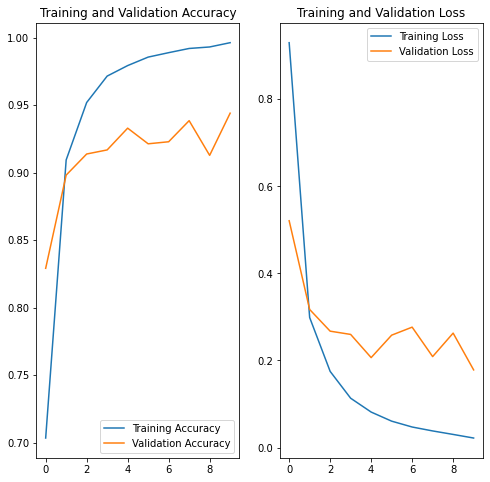

In [26]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
print("accuracy : ", acc)
print("loss : ", loss)

accuracy :  [0.7034029960632324, 0.9094194769859314, 0.9519572854042053, 0.9715302586555481, 0.979314923286438, 0.9855983257293701, 0.9888790249824524, 0.9919928908348083, 0.9931049942970276, 0.996274471282959]
loss :  [0.9296032190322876, 0.298631876707077, 0.17495711147785187, 0.11335593461990356, 0.08159466087818146, 0.060721080750226974, 0.0472811795771122, 0.03827203810214996, 0.030240029096603394, 0.021965399384498596]


In [30]:
# Evaluation 

model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

63/63 [==============================] - 3s 41ms/step - loss: 0.1790 - accuracy: 0.9440
loss value: 0.179
accuracy value: 94.4000%
